In [ ]:
import argparse

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dgl.data import GINDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SubsetRandomSampler

import networkx as nx
import matplotlib.pyplot as plt

import functools
from tqdm import tqdm
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from torch.utils.data import DataLoader
from pydantic import BaseModel
from Bio.SeqUtils import GC
from typing import Any, Dict, List, Optional, Set, Type, Union, Tuple
from pathlib import Path
PathLike = Union[str, Path]
from torch.utils.data import Dataset
import re
from collections import Counter, defaultdict
from operator import itemgetter
import random
from transformers import PreTrainedTokenizerFast, AutoModelForCausalLM, AutoConfig, BatchEncoding
from transformers.utils import ModelOutput
from tokenizers import Tokenizer
from bertviz import model_view
#from genslm import GenSLM, SequenceDataset


In [ ]:

class GenSLM(nn.Module):

    __genslm_path = Path("/home/couchbucks/Documents/saketh/GeneNN/genslm/genslm")
    __tokenizer_path = __genslm_path / "tokenizer_files"
    __architecture_path = __genslm_path / "architectures"

    MODELS: Dict[str, Dict[str, str]] = {
        "genslm_25M_patric": {
            "config": str(__architecture_path / "neox" / "neox_25,290,752.json"),
            "tokenizer": str(__tokenizer_path / "codon_wordlevel_69vocab.json"),
            "weights": "patric_25m_epoch01-val_loss_0.57_bias_removed.pt",
            "seq_length": "2048",
        },
        "genslm_250M_patric": {
            "config": str(__architecture_path / "neox" / "neox_244,464,576.json"),
            "tokenizer": str(__tokenizer_path / "codon_wordlevel_69vocab.json"),
            "weights": "patric_250m_epoch00_val_loss_0.48_attention_removed.pt",
            "seq_length": "2048",
        },
        "genslm_2.5B_patric": {
            "config": str(__architecture_path / "neox" / "neox_2,533,931,008.json"),
            "tokenizer": str(__tokenizer_path / "codon_wordlevel_69vocab.json"),
            "weights": "patric_2.5b_epoch00_val_los_0.29_bias_removed.pt",
            "seq_length": "2048",
        },
        "genslm_25B_patric": {
            "config": str(__architecture_path / "neox" / "neox_25,076,188,032.json"),
            "tokenizer": str(__tokenizer_path / "codon_wordlevel_69vocab.json"),
            "weights": "model-epoch00-val_loss0.70-v2.pt",
            "seq_length": "2048",
        },
    }

    def __init__(self, model_id: str, model_cache_dir: PathLike = ".") -> None:
        """GenSLM inference module.

        Parameters
        ----------
        model_id : str
            A model ID corresponding to a pre-trained model. (e.g., genslm_25M_patric)
        model_cache_dir : PathLike, optional
            Directory where model weights have been downloaded to (defaults to current
            working directory). If model weights are not found, then they will be
            downloaded, by default "."

        Raises
        ------
        ValueError
            If model_id is invalid.
        """
        super().__init__()
        self.model_cache_dir = Path(model_cache_dir)
        self.model_info = self.MODELS.get(model_id)
        if self.model_info is None:
            valid_model_ids = list(self.MODELS.keys())
            raise ValueError(
                f"Invalid model_id: {model_id}. Please select one of {valid_model_ids}"
            )

        self._tokenizer = self.configure_tokenizer()
        self.model = self.configure_model()

    @property
    def seq_length(self) -> int:
        assert self.model_info is not None
        return int(self.model_info["seq_length"])

    @property
    def tokenizer(self) -> PreTrainedTokenizerFast:
        return self._tokenizer

    def configure_model(self) -> AutoModelForCausalLM:
        assert self.model_info is not None
        base_config = AutoConfig.from_pretrained(self.model_info["config"])
        model = AutoModelForCausalLM.from_config(base_config)

        weight_path = self.model_cache_dir / self.model_info["weights"]
        if not weight_path.exists():
            # TODO: Implement model download
            raise NotImplementedError
        ptl_checkpoint = torch.load(weight_path, map_location="cpu")
        model.load_state_dict(ptl_checkpoint["state_dict"], strict=False)
        return model

    def configure_tokenizer(self) -> PreTrainedTokenizerFast:
        assert self.model_info is not None
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        tokenizer = PreTrainedTokenizerFast(
            tokenizer_object=Tokenizer.from_file(self.model_info["tokenizer"])
        )
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
        return tokenizer

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor, **kwargs: Any
    ) -> ModelOutput:
        return self.model(
            input_ids, labels=input_ids, attention_mask=attention_mask, **kwargs
        )

In [ ]:
class SequenceDataset(Dataset):  # type: ignore[type-arg]
    """Dataset initialized from a list of sequence strings."""

    def __init__(
        self,
        sequences: List[str],
        seq_length: int,
        tokenizer: PreTrainedTokenizerFast,
        kmer_size: int = 3,
        verbose: bool = True,
    ):
        self.batch_encodings = self.tokenize_sequences(
            sequences, tokenizer, seq_length, kmer_size, verbose
        )

    @staticmethod
    def tokenize_sequences(
        sequences: List[str],
        tokenizer: PreTrainedTokenizerFast,
        seq_length: int,
        kmer_size: int = 3,
        verbose: bool = True,
    ) -> List[BatchEncoding]:

        tokenizer_fn = functools.partial(
            tokenizer,
            max_length=seq_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        batch_encodings = [
            tokenizer_fn(SequenceDataset.group_by_kmer(seq, kmer_size))
            for seq in tqdm(sequences, desc="Tokenizing...", disable=not verbose)
        ]
        return batch_encodings

    @staticmethod
    def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()

    def __len__(self) -> int:
        return len(self.batch_encodings)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        batch_encoding = self.batch_encodings[idx]
        # Squeeze so that batched tensors end up with (batch_size, seq_length)
        # instead of (batch_size, 1, seq_length)
        sample = {
            "input_ids": batch_encoding["input_ids"].squeeze(),
            "attention_mask": batch_encoding["attention_mask"],
        }
        return sample

In [73]:
model = GenSLM("genslm_25M_patric", model_cache_dir="/home/couchbucks/Documents/saketh/GeneNN/GeneNN/")
model.eval()

GenSLM(
  (model): GPTNeoXForCausalLM(
    (gpt_neox): GPTNeoXModel(
      (embed_in): Embedding(69, 512)
      (layers): ModuleList(
        (0-7): 8 x GPTNeoXLayer(
          (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attention): GPTNeoXAttention(
            (rotary_emb): RotaryEmbedding()
            (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
            (dense): Linear(in_features=512, out_features=512, bias=True)
          )
          (mlp): GPTNeoXMLP(
            (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
            (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
            (act): FastGELUActivation()
          )
        )
      )
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (embed_out): Linear(in_features=512, out_featur

In [ ]:
sequences = [
    "ATGAAC",
]

dataset = SequenceDataset(sequences, model.seq_length, model.tokenizer)
print(dataset)
dataloader = DataLoader(dataset)
print(dataloader)
# Compute averaged-embeddings for each input sequence
embeddings = []
outputs = []
with torch.no_grad():
    for batch in dataloader:
        #print(batch["input_ids"])
        outputs = model(
            batch["input_ids"],
            batch["attention_mask"],
            #output_hidden_states=True,
            output_attentions=True
        )
        attention = outputs.attentions[0]
        last_tensor = attention[0, -1, :, :]
        # print(batch['input_ids'])
        # tokens = model.tokenizer.convert_ids_to_tokens(batch['input_ids'].flatten())  # Convert input ids to token strings
        # print(attention.shape)
        # model_view(attention, tokens)
        print(model.tokenizer.pad_token_id)
        print(last_tensor.shape)
            
                   
        
        # outputs.hidden_states shape: (layers, batch_size, sequence_length, hidden_size)
        # Use the embeddings of the last layer
        

In [ ]:
def find_last_attention_mask(seq, model):
    tokenized_seq = model.tokenizer(
        SequenceDataset.group_by_kmer(seq, 3),
        max_length=model.seq_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
        )
    
    outputs = model(
        tokenized_seq["input_ids"],
        tokenized_seq["attention_mask"],
        #output_hidden_states=True,
        output_attentions=True
        )
    attention = outputs.attentions[0]
    last_tensor = attention[0, -1, :, :]
    return last_tensor


ACTTTA
tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9925, 0.0075, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2293, 0.1015, 0.6692,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0519, 0.8377, 0.0722,  ..., 0.0000, 0.0000, 0.0000],
        [0.0484, 0.8423, 0.0727,  ..., 0.0000, 0.0000, 0.0000],
        [0.0460, 0.8441, 0.0743,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<SliceBackward0>)


In [ ]:

def codons_to_graph(sequence, num_feats, max_len_codon, attention_weights):
    codon_numbers = convert_codons_to_nums(sequence)
    codon_polarity = convert_codons_to_polarity(sequence)
    amino_acids = convert_codons_to_aa(sequence)
    
    num_codons = len(codon_numbers)
    
    # Initialize source and destination nodes for all edges
    src_nodes = []
    dst_nodes = []
    edge_weights = []
    
    # Connect each node to every other node
    for i in range(max_len_codon):
        for j in range(max_len_codon):
            src_nodes.append(i)
            dst_nodes.append(j)
        
    for i, j in zip(src_nodes, dst_nodes):
        weight = attention_weights[i, j]
        edge_weights.append(weight.item())
    
    g = dgl.graph((src_nodes, dst_nodes), num_nodes=max_len_codon)
    g.edata['weight'] = torch.tensor(edge_weights, dtype=torch.float32).view(-1, 1)
    
    # Initialize node features tensor
    node_features = torch.zeros(max_len_codon, num_feats, dtype=torch.float32)
    
    # Assign features to nodes
    for i, (num, polar, aa) in enumerate(zip(codon_numbers, codon_polarity, amino_acids)):
        node_features[i][0] = num
        node_features[i][1] = polar
        node_features[i][2] = aa
    
    # Assign node features to the graph
    g.ndata["feature"] = node_features
    
    return g
    
CODON_TO_AA = {
    'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
    'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
    'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
    'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
    'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
    'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
    'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
    'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
    'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
    'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
    'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
    'TAC': 'Y', 'TAT': 'Y', 'TAA': '_', 'TAG': '_',
    'TGC': 'C', 'TGT': 'C', 'TGA': '_', 'TGG': 'W',
    'XXX':'X'
}


AA_TO_POLARITY = {
    'T': 'polar', 'S': 'polar', 'N': 'polar', 'Q': 'polar',
    'A': 'nonpolar', 'V': 'nonpolar', 'I': 'nonpolar', 'L': 'nonpolar', 'M': 'nonpolar', 'F': 'nonpolar', 'Y': 'nonpolar', 'W': 'nonpolar',
    'R': 'positive', 'H': 'positive', 'K': 'positive', 
    'D': 'negative', 'E': 'negative',
    'C': 'special', 'G': 'special', 'P': 'special', 'X': 'special', '_': 'special'
}

# Define a mapping from codons to their polarity
CODON_POLARITY = {codon:AA_TO_POLARITY[CODON_TO_AA[codon]] for codon in CODON_TO_AA}
POLARITY_NUM = {
    "polar": 0,
    "nonpolar": 1,
    "positive": 2,
    "negative": 3,
    "special": 4
}

AMINO_ACIDS = ['R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'C', 'G', 'P', '_', 'X']

CODON_LETTER_NUMBER_ASSIGN = dict(zip(CODON_TO_AA, range(len(CODON_TO_AA))))
AMINO_ACID_NUM_ASSIGN = dict(zip(AMINO_ACIDS, range(len(AMINO_ACIDS)))) 

def convert_codons_to_nums(codon_seq):
    return [CODON_LETTER_NUMBER_ASSIGN[codon] for codon in codon_seq]

def convert_codons_to_polarity(codon_seq):
    return [POLARITY_NUM[CODON_POLARITY[codon]] for codon in codon_seq]

def convert_codons_to_aa(codon_seq):
    return [AMINO_ACID_NUM_ASSIGN[CODON_TO_AA[codon]] for codon in codon_seq]



BASES = ["A", "T", "C", "G", "a", "t", "c", "g"]


AMINO_ACIDS = ['R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'C', 'G', 'P', '_', 'X']

# Mapping codon letters to int
CODON_LETTER_NUMBER_ASSIGN = dict(zip(CODON_TO_AA, range(len(CODON_TO_AA))))

# Mapping AA label to int
AA_IDX_TOTAL = dict(zip(AMINO_ACIDS, range(len(AMINO_ACIDS))))


In [ ]:
def seq_to_codon_list(seq: str) -> List[str]:
    """split the sequence string into strings of len 3"""
    return [seq[i : i + 3] for i in range(0, len(seq), 3)]

sequence = "ACTTTAAAT"


graph = codons_to_graph(seq_to_codon_list(sequence), 3, 10, attention_weights = find_last_attention_mask(sequence, model))

In [ ]:
weights = find_last_attention_mask(sequence, model)


In [ ]:
torch.set_printoptions(threshold=10_000)

graph.edata['weight']

tensor([[1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8189],
        [0.1811],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.4227],
        [0.3076],
        [0.2697],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2970],
        [0.3542],
        [0.3488],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2902],
        [0.3667],
        [0.3431],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2806],
        [0.3789],
        [0.3405],
        [0.0000],
        [0.0000],
        [0

NetworkXError: draw_networkx_edge_labels does not support multiedges.

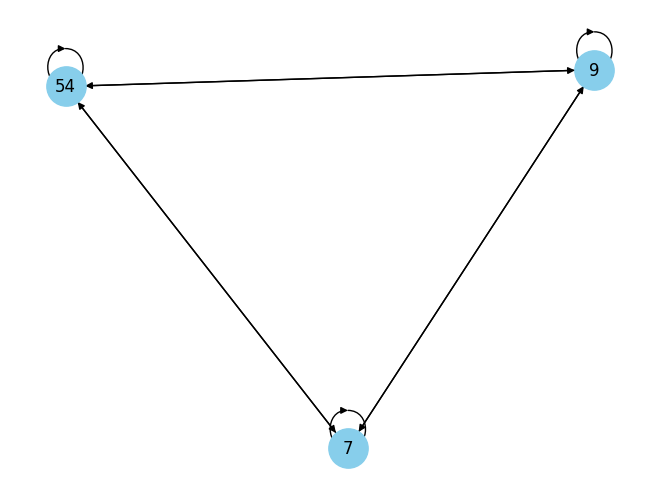

In [ ]:


codon_num_list = convert_codons_to_nums(seq_to_codon_list(sequence))


def visualize_graph(graph, codon_numbers):
    nx_graph = graph.to_networkx()  # Convert DGL graph to NetworkX graph
    pos = nx.spring_layout(nx_graph)  # Choose a layout for visualization

    # Draw the graph with node labels as codon numbers
    labels = {i: str(codon_num) for i, codon_num in enumerate(codon_numbers)}
    nx.draw(nx_graph, pos, with_labels=True, labels=labels, node_color='skyblue', node_size=800)

    # Add edge labels for attention weights
    edge_labels = {edge: f'{graph.edata["weight"][k].item():.2f}' for k, edge in enumerate(graph.edges())}
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels)

    plt.show()
    
visualize_graph(graph, codon_num_list)